In [1]:
import os
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ivolatility as ivol

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

from nelson_siegel_svensson.calibrate import calibrate_nss_ols

# Models definitions

## Heston Model

In [62]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
        S0: initial asset price
        v0: initial variance
        kappa: mean reversion rate
        theta: long-term average volatility
        sigma: volatility of volatility
        rho: correlation between returns and variances under risk-neutral dynamics
        lambd: ?
        tau: ?
        r: ?
    """
    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1 * term2 * exp2


def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r * tau) * heston_charfunc(phi - 1j, *args) - K * heston_charfunc(phi, *args)
    denominator = 1j * phi * K ** (1j * phi) 
    return numerator/denominator


def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi = umax / N #dphi is width

    for i in range(1, N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau) * heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)


def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

## Merton Jump Model

In [59]:
# --- Part 1: Merton Characteristic Function ---
def merton_charfunc(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Characteristic function for the Merton Jump Diffusion Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (np.exp(1j * phi * mu_j - 0.5 * sigma_j**2 * phi**2) - 1)
    return exp1 * np.exp(diffusion + jumps)

# --- Part 2: Integrand for Numerical Integration ---
def integrand_merton(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r, K):
    """
    Integrand for numerical integration in the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Part 3: Rectangular Numerical Integration ---
def merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using rectangular integration for the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Part 4: Option Price Using Scipy Quad Integration ---
def merton_price(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using scipy quad integration for the Merton Jump Diffusion Model.
    """
    real_integral, err = np.real(quad(integrand_merton, 0, 100, args=(S0, sigma, lambd, mu_j, sigma_j, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi


## Kou Model

In [60]:
# --- Step 1: Kou Characteristic Function ---
def kou_charfunc(phi, S0, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Characteristic function for the Kou Double Exponential Jump Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (p * eta1 / (eta1 + 1) + (1 - p) * eta2 / (eta2 + 1) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (
        p * eta1 / (eta1 - 1j * phi) + (1 - p) * eta2 / (eta2 + 1j * phi) - 1
    )
    return exp1 * np.exp(diffusion + jumps)

# --- Step 2: Integrand for Numerical Integration ---
def integrand_kou(phi, S0, sigma, lambd, p, eta1, eta2, tau, r, K):
    """
    Integrand for numerical integration in the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Step 3: Rectangular Numerical Integration ---
def kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using rectangular integration for the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Step 4: Option Price Using Scipy Quad Integration ---
def kou_price(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using scipy quad integration for the Kou model.
    """
    real_integral, err = np.real(quad(integrand_kou, 0, 100, args=(S0, sigma, lambd, p, eta1, eta2, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi

## Variance Gamma Model

In [61]:
def vg_charfunc(phi, S0, theta, sigma, nu, tau, r):
    """
    Variance Gamma characteristic function of ln(S_tau).
    
    ----------
    Parameters
    phi   : float or ndarray
        Frequency argument of the characteristic function.
    S0    : float
        Spot price at t=0.
    theta : float
        'Drift' parameter of the VG subordinator (sometimes denoted as θ).
    sigma : float
        'Vol' parameter of the VG subordinator.
    nu    : float
        'Gamma' parameter (sometimes 1/kappa in other notations).
    tau   : float
        Time to maturity (T - 0).
    r     : float
        Risk-free interest rate.
    -------
    Notes
    The key difference from Heston is the explicit "martingale adjustment" ω:
        ω = - (1/nu) * ln(1 - theta*nu - 0.5*sigma^2 * nu)
    so that discounted S_t is a martingale under the risk-neutral measure.
    -----
    """
    # Martingale adjustment: ensure E[e^{-r tau} * S_tau] = S_0
    omega = -(1.0 / nu) * np.log(1.0 - theta*nu - 0.5*sigma**2 * nu)
    
    # VG characteristic function for ln(S_tau):
    #   exp{ i φ [ ln(S0) + (r + ω)*τ ] } * (1 - i θ ν φ + 0.5 σ^2 ν φ^2)^(-τ/ν)
    return np.exp(
        1j * phi * (np.log(S0) + (r + omega) * tau)
    ) * (
        (1.0 - 1j * theta * nu * phi + 0.5 * (sigma ** 2) * nu * (phi ** 2)) ** (-tau / nu)
    )


def integrand_vg(phi, S0, K, theta, sigma, nu, tau, r):
    """
    Parameters
    phi   : float
        Integration variable (Fourier frequency).
    S0, K : float
        Spot (S0) and strike (K).
    theta, sigma, nu, tau, r : float
        VG parameters and maturity/rate.
    """
    numerator = (
        np.exp(1j * phi * r * tau) * vg_charfunc(phi - 1j, S0, theta, sigma, nu, tau, r)
        - K * vg_charfunc(phi, S0, theta, sigma, nu, tau, r)
    )
    denominator = 1j * phi * (1j * phi + 1.0)
    
    return numerator / denominator


def vg_price_rec(S0, K, theta, sigma, nu, tau, r):
    """
    Parameters
    S0, K : float
        Spot and strike.
    theta, sigma, nu : float
        VG parameters.
    tau   : float
        Time to maturity.
    r     : float
        Risk-free interest rate.
    """
   
    phi_max = 100.0
    N = 10000
    dphi = phi_max / N
    
    P = 0.0
    for i in range(1, N):
        # midpoint in each subinterval (rectangular rule)
        phi = dphi * (2 * i - 1) / 2.0
        P += dphi * integrand_vg(phi, S0, K, theta, sigma, nu, tau, r)
    
    return np.real( (S0 - K * np.exp(-r * tau)) / 2.0 + P / np.pi )

# Set up and Get Data

In [6]:
username = 'PutYourIVolatilityUSernameHere'
password = 'PutYourIVolatilityPasswordHere'

In [7]:
# loginto the IVol account
ivol.setLoginParams(username=username, password=password)

In [8]:
# Define the parameters for the options
# If the relative data is already present in the data folder, load it from there instead of querying the IVol API
symbol =            'UCG'
tradeDate =         '2024-10-04'
last_trade_date =   '2024-10-09'
region =            'EUROPE'
dteFrom =           10
dteTo =             1000
cp =                'C'
deltaFrom =         0
deltaTo =           1

In [9]:
data_path = f'../data/{symbol}_{region}_{tradeDate}_dteFrom{dteFrom}-To{dteTo}_cp{cp}_deltaFrom{deltaFrom}-To{deltaTo}.csv'
data_path

'../data/UCG_EUROPE_2024-10-04_dteFrom10-To1000_cpC_deltaFrom0-To1.csv'

In [10]:
if not os.path.exists(data_path):
    getMarketData = ivol.setMethod('/equities/eod/stock-opts-by-param')
    marketData = getMarketData(
        symbol=symbol, 
        tradeDate=tradeDate, 
        region=region,
        cp='C', 
        dteFrom=dteFrom, dteTo=dteTo, 
        deltaFrom=deltaFrom, deltaTo=deltaTo
    )
    marketData.to_csv(data_path)
else:
    marketData = pd.read_csv(data_path)
marketData

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,preiv,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id
0,2024-10-04 00:00:00.0,1UCG 241004C00000320000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-17.57,NaN
1,2024-10-04 00:00:00.0,1UCG 241004C00000325000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-16.28,NaN
2,2024-10-04 00:00:00.0,1UCG 241004C00000330000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-14.99,NaN
3,2024-10-04 00:00:00.0,1UCG 241004C00000335000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-13.70,NaN
4,2024-10-04 00:00:00.0,1UCG 241004C00000340000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,34.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-12.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2024-10-04 00:00:00.0,UCG 270618C00000960000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,96.0,0.0,0.0,0.0,...,0.267132,0.003354,-0.000404,0.027316,0.016001,0.001,0.001,38.82,147.30,NaN
549,2024-10-04 00:00:00.0,UCG 270618C00001000000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,100.0,0.0,0.0,0.0,...,0.268345,0.002819,-0.000341,0.023059,0.013151,0.001,0.001,38.82,157.60,NaN
550,2024-10-04 00:00:00.0,UCG 270618C00001040000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,104.0,0.0,0.0,0.0,...,0.267728,0.002298,-0.000277,0.018758,0.010388,0.001,0.001,38.82,167.90,NaN
551,2024-10-04 00:00:00.0,UCG 270618C00001080000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,108.0,0.0,0.0,0.0,...,0.267938,0.001901,-0.000229,0.015528,0.008382,0.001,0.001,38.82,178.21,NaN


In [11]:
marketData.columns

Index(['c_date', 'option_symbol', 'dte', 'stocks_id', 'expiration_date',
       'call_put', 'price_strike', 'price_open', 'price_high', 'price_low',
       'price', 'volume', 'openinterest', 'iv', 'delta', 'preiv', 'gamma',
       'theta', 'vega', 'rho', 'Ask', 'Bid', 'underlying_price', 'calc_OTM',
       'option_id'],
      dtype='object')

## Compute strikes and maturities

In [12]:
def calc_maturity(date):
    #invece che today mettere a data desiderata vecchia, per non avere maturities negative
    return ((dt.strptime(date, '%Y-%m-%d %H:%M:%S.%f') - dt.today()).days / 365.25)

In [13]:
all_strikes = [date_group['price_strike'].tolist() for date, date_group in marketData.groupby('expiration_date')]
common_strikes = sorted(set.intersection(*map(set, all_strikes)))

In [14]:
num_exp_days = marketData['expiration_date'].unique().shape[0]
print(f"Number of expiration days: {num_exp_days} - number of common strikes: {len(common_strikes)}")

Number of expiration days: 12 - number of common strikes: 6


In [15]:
maturities = []
all_prices = []

for date, date_group in marketData.groupby('expiration_date'):
    maturities.append(calc_maturity(date))
    # prices = date_group[date_group['price_strike'].isin(common_strikes)]['price'].tolist()
    prices = [date_group['price'].tolist()[i] for i,x in enumerate(date_group['price_strike'].tolist()) if x in common_strikes][:len(common_strikes)]
    all_prices.append(prices)

price_arr = np.array(all_prices)
price_arr.shape

(12, 6)

## Compute volatility surface

In [16]:
vol_surface = pd.DataFrame(price_arr, index=maturities, columns=common_strikes)
vol_surface

,34.0,36.0,38.0,40.0,44.0,48.0
-0.276523,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
-0.257358,4.8450,2.8888,1.1265,0.1859,0.0003,0.0010
-0.238193,4.9290,3.0438,1.4198,0.4322,0.0189,0.0002
-0.161533,5.3502,3.6499,2.2666,1.2374,0.2726,0.0437
-0.065708,5.4525,3.8561,2.4916,1.4956,0.4435,0.1284
0.183436,6.0207,4.5976,3.3957,2.4294,1.1324,0.4864
0.432580,6.3252,4.9928,3.8220,2.8566,1.5202,0.7532
0.681725,6.6299,5.3485,4.2329,3.3003,1.9405,1.1129
0.930869,6.9528,5.7198,4.6639,3.7497,2.3922,1.4838
1.429158,7.0144,5.8329,4.8055,3.9439,2.6551,1.8221


In [17]:
vol_surface_long = vol_surface.melt(ignore_index=False).reset_index()
vol_surface_long.columns = ['maturity', 'strike', 'price']
vol_surface_long

,maturity,strike,price
0,-0.276523,34.0,0.0010
1,-0.257358,34.0,4.8450
2,-0.238193,34.0,4.9290
3,-0.161533,34.0,5.3502
4,-0.065708,34.0,5.4525
...,...,...,...
67,0.681725,48.0,1.1129
68,0.930869,48.0,1.4838
69,1.429158,48.0,1.8221
70,1.927447,48.0,2.2106


In [18]:
# Put there the correct values
yield_maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([4.93, 4.84, 4.75, 4.65, 4.46, 4.24, 3.99, 3.89, 3.91, 3.97, 4.06, 4.41, 4.34]).astype(float) / 100

In [19]:
# NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities, yeilds)
curve_fit

NelsonSiegelSvenssonCurve(beta0=np.float64(0.044103308774897605), beta1=np.float64(0.005354152287744192), beta2=np.float64(-0.03515848351569766), beta3=np.float64(0.009899518690519308), tau1=np.float64(2.0), tau2=np.float64(5.0))

In [20]:
vol_surface_long['rate'] = vol_surface_long['maturity'].apply(curve_fit)
vol_surface_long

,maturity,strike,price,rate
0,-0.276523,34.0,0.0010,0.049457
1,-0.257358,34.0,4.8450,0.049457
2,-0.238193,34.0,4.9290,0.049457
3,-0.161533,34.0,5.3502,0.049457
4,-0.065708,34.0,5.4525,0.049457
...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467
68,0.930869,48.0,1.4838,0.043163
69,1.429158,48.0,1.8221,0.041185
70,1.927447,48.0,2.2106,0.039868


# Apply the Models

In [21]:
def get_last_trade_price(symbol, date, region):
    """Get the last trade price. Requires an active IVol account """
    getMarketData_stocks = ivol.setMethod('/equities/eod/stock-prices')
    marketData_stocks = getMarketData_stocks(symbol=symbol, date=date, region=region)
    return float(marketData_stocks['close'].iloc[0])

In [22]:
def callback(*args):
    global iteration, start, prev, stat
    if iteration == 0:
        print('#iterations\tstep time (s)\ttotal time (s)')
    step = round(time.time() - prev, 3)
    total = round(time.time() - start, 3)
    print(f'{iteration}\t\t{step}\t\t{total}')
    prev = time.time()
    stat.append([iteration, step, total])
    iteration += 1

In [23]:
def plot_time_stat(model_name, steps, totals, color):
    plt.plot(steps  , '-',  color=color, label=f'{model_name}-step time (s)')
    plt.plot(totals , '--', color=color, label=f'{model_name}-cumulative time (s)')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('time (s)')

In [65]:
# General parameters used in the optimization process
method = 'Nelder-Mead'
max_iter = 1e4
tolerance = 1e-3

# put real data there using the function get_last_trade_price defined above 
last_trade_price = 100 

## Heston Model

In [63]:
# Define variables to be used in optimization
S0 =    last_trade_price # get_last_trade_price(symbol, last_trade_date)
r =     vol_surface_long['rate'].to_numpy('float')
K =     vol_surface_long['strike'].to_numpy('float')
tau =   vol_surface_long['maturity'].to_numpy('float')
P =     vol_surface_long['price'].to_numpy('float')

params = {
    "v0"    : {"x0": 0.1,   "lbub": [1e-3,  0.1]},
    "kappa" : {"x0": 3,     "lbub": [1e-3,  5]},
    "theta" : {"x0": 0.05,  "lbub": [1e-3,  0.1]},
    "sigma" : {"x0": 0.3,   "lbub": [1e-2,  1]},
    "rho"   : {"x0": -0.8,  "lbub": [-1,    0]},
    "lambd" : {"x0": 0.03,  "lbub": [-1,    1]},
}

x0 =    [param["x0"]    for key, param in params.items()]
bnds =  [param["lbub"]  for key, param in params.items()]

In [ ]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])

    # Decided to use rectangular integration function in the end
    err = np.sum( (P - heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = 0 # np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen

start = time.time()
prev = time.time()
iteration = 0
stat = heston_stat = []

result = minimize(SqErr, x0, tol=tolerance, method=method, options={'maxiter': max_iter}, bounds=bnds, callback=callback)

#iterations	step time (s)	total time (s)
0		5.871		5.871
1		0.737		6.608
2		1.467		8.075
3		0.75		8.825
4		1.46		10.285
5		1.513		11.798
6		0.749		12.547
7		1.483		14.031
8		1.526		15.557
9		0.762		16.319
10		1.526		17.844
11		0.857		18.701
12		1.524		20.225
13		0.755		20.98
14		1.587		22.566
15		1.538		24.105
16		0.762		24.867
17		0.812		25.679
18		0.768		26.447
19		0.764		27.211
20		0.831		28.042
21		0.774		28.816
22		6.147		34.963
23		1.535		36.499
24		1.545		38.044
25		0.799		38.843
26		1.516		40.359
27		1.571		41.93
28		0.77		42.7
29		1.51		44.211
30		1.539		45.75
31		1.546		47.296
32		1.556		48.852
33		0.76		49.612
34		1.521		51.133
35		0.759		51.892
36		1.532		53.424
37		0.759		54.183
38		1.523		55.706
39		1.523		57.229
40		1.52		58.75
41		0.794		59.543
42		0.753		60.296
43		0.753		61.049
44		0.011		61.06


KeyboardInterrupt: 

In [29]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3305.707526399099
             x: [ 3.815e-02  1.408e+00  1.913e-03  5.239e-01 -6.922e-01
                  1.220e-01]
           nit: 301
          nfev: 500
 final_simplex: (array([[ 3.815e-02,  1.408e+00, ..., -6.922e-01,
                         1.220e-01],
                       [ 3.815e-02,  1.408e+00, ..., -6.922e-01,
                         1.220e-01],
                       ...,
                       [ 3.815e-02,  1.408e+00, ..., -6.922e-01,
                         1.220e-01],
                       [ 3.815e-02,  1.408e+00, ..., -6.922e-01,
                         1.220e-01]]), array([ 3.306e+03,  3.306e+03,  3.306e+03,  3.306e+03,
                        3.306e+03,  3.306e+03,  3.306e+03]))

In [30]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
print(f"v0={v0}, kappa={kappa}, theta={theta}, sigma={sigma}, rho={rho}, lambda={lambd}")

v0=0.038150020734656086, kappa=1.4080133469704559, theta=0.0019133137849933815, sigma=0.5238859206697314, rho=-0.6921804444390449, lambda=0.12200679131244008


In [31]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
vol_surface_long['heston_price'] = heston_prices
vol_surface_long

,maturity,strike,price,rate,heston_price
0,-0.276523,34.0,0.0010,0.049457,57.736176
1,-0.257358,34.0,4.8450,0.049457,53.537189
2,-0.238193,34.0,4.9290,0.049457,49.386623
3,-0.161533,34.0,5.3502,0.049457,34.835421
4,-0.065708,34.0,5.4525,0.049457,51.974115
...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.708827
68,0.930869,48.0,1.4838,0.043163,57.005947
69,1.429158,48.0,1.8221,0.041185,59.511262
70,1.927447,48.0,2.2106,0.039868,61.827823


In [32]:
vol_surface_long['heston_difference'] = vol_surface_long['price'] - vol_surface_long['heston_price']
vol_surface_long['heston_difference'].describe()

count    72.000000
mean    -55.210496
std      16.159687
min     -88.069980
25%     -65.273010
50%     -60.527898
75%     -50.136744
max     -14.911173
Name: heston_difference, dtype: float64

## Merton Jump Model

In [33]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

params = {
    "sigma"     : {"x0": 0.2, "lbub": [1e-2, 1]},
    "lambd"     : {"x0": 0.1, "lbub": [1e-3, 1]},
    "mu_j"      : {"x0": 0,   "lbub": [-1, 1]},
    "sigma_j"   : {"x0": 0.1, "lbub": [1e-2, 1]},
}

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

In [34]:
def SqErr_merton(x):
    sigma, lambd, mu_j, sigma_j = x
    return np.sum((P - merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r))**2 / len(P))

In [35]:
start = time.time()
prev = time.time()
iteration = 0
stat = merton_stat = []

result = minimize(SqErr_merton, x0, tol=tolerance, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		2.355		2.355
1		0.343		2.698
2		0.335		3.033
3		0.687		3.721
4		0.666		4.387
5		0.331		4.718
6		0.659		5.377
7		0.658		6.035
8		0.33		6.365
9		0.33		6.695
10		0.329		7.025
11		0.658		7.683
12		0.659		8.341
13		0.691		9.033
14		0.694		9.728
15		0.661		10.389
16		0.347		10.736
17		0.661		11.397
18		0.661		12.058
19		0.657		12.715
20		0.659		13.374
21		0.657		14.032
22		0.658		14.689
23		0.657		15.346
24		0.658		16.004
25		0.657		16.662
26		0.659		17.321
27		0.657		17.978
28		0.659		18.637
29		0.658		19.295
30		0.329		19.625
31		0.657		20.282
32		0.657		20.939
33		0.33		21.269
34		0.328		21.597
35		0.658		22.256
36		0.657		22.913
37		0.658		23.571
38		0.657		24.228
39		0.33		24.558
40		0.329		24.887
41		0.656		25.544
42		0.658		26.202
43		0.329		26.531
44		0.337		26.868
45		0.662		27.53
46		0.709		28.239
47		0.332		28.571
48		0.661		29.232
49		0.662		29.895
50		0.332		30.226
51		0.662		30.888
52		0.663		31.551
53		0.335		31.887
54		0.332		32.218

In [36]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3411.6994861458015
             x: [ 6.287e-02  1.000e+00 -4.808e-02  1.516e-01]
           nit: 440
          nfev: 745
 final_simplex: (array([[ 6.287e-02,  1.000e+00, -4.808e-02,  1.516e-01],
                       [ 6.287e-02,  9.999e-01, -4.809e-02,  1.516e-01],
                       ...,
                       [ 6.287e-02,  9.999e-01, -4.808e-02,  1.516e-01],
                       [ 6.287e-02,  9.999e-01, -4.807e-02,  1.515e-01]]), array([ 3.412e+03,  3.412e+03,  3.412e+03,  3.412e+03,
                        3.412e+03]))

In [37]:
sigma, lambd, mu_j, sigma_j = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, mu_j={mu_j}, sigma_j={sigma_j}")

# --- Final Volatility Surface and Comparison ---
merton_prices = merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r)
vol_surface_long['merton_price'] = merton_prices
vol_surface_long['merton_difference'] = vol_surface_long['price'] - vol_surface_long['merton_price']
vol_surface_long['merton_difference'].describe()

Calibrated parameters: sigma=0.0628730041444909, lambd=0.9999890226554036, mu_j=-0.04808247793641193, sigma_j=0.15157071386316245


count    72.000000
mean    -56.979035
std      12.938866
min     -79.342207
25%     -63.316531
50%     -59.574470
75%     -54.520319
max       0.651946
Name: merton_difference, dtype: float64

In [38]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,58.182749,-55.210496,59.951288,-56.979035
std,0.887791,4.794363,2.264968,0.003923,16.668685,16.159687,13.886769,12.938866
min,-0.276523,34.000000,0.000200,0.039040,15.997710,-88.069980,-0.650946,-79.342207
25%,-0.180698,36.000000,1.022975,0.042668,52.719931,-65.273010,56.797360,-63.316531
50%,0.308008,39.000000,2.872700,0.046953,63.810893,-60.527898,62.945277,-59.574470
75%,1.055441,44.000000,4.866000,0.049457,68.763483,-50.136744,68.293997,-54.520319
max,2.425736,48.000000,7.215400,0.049457,88.113680,-14.911173,79.343207,0.651946


## Kou Model

In [39]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

params = {
    "sigma" : {"x0": 0.2,   "lbub": [1e-2, 1]},
    "lambd" : {"x0": 0.1,   "lbub": [1e-3, 1]},
    "p"     : {"x0": 0.5,   "lbub": [0.01, 0.99]},
    "eta1"  : {"x0": 10,    "lbub": [1, 20]},
    "eta2"  : {"x0": 10,    "lbub": [1, 20]},
}

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

In [40]:
def SqErr(x):
    sigma, lambd, p, eta1, eta2 = x
    return np.sum((P - kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r))**2 / len(P))

In [41]:
iteration = 0
start = time.time()
prev = time.time()
stat = kou_stat = []

result = minimize(SqErr, x0, tol=tolerance, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		2.722		2.722
1		0.341		3.063
2		0.341		3.404
3		0.341		3.745
4		0.679		4.424
5		0.679		5.103
6		0.339		5.443
7		0.678		6.121
8		0.34		6.461
9		0.679		7.14
10		0.339		7.479
11		0.678		8.158
12		0.34		8.498
13		0.34		8.838
14		0.34		9.178
15		0.339		9.517
16		0.34		9.857
17		0.34		10.197
18		0.341		10.538
19		0.34		10.878
20		0.678		11.555
21		0.678		12.233
22		0.677		12.911
23		0.678		13.589
24		0.678		14.267
25		0.68		14.947
26		0.677		15.625
27		0.677		16.302
28		0.677		16.979
29		0.678		17.657
30		0.678		18.335
31		0.678		19.013
32		0.676		19.689
33		0.683		20.372
34		0.683		21.055
35		0.339		21.394
36		0.677		22.071
37		0.678		22.749
38		0.691		23.44
39		0.683		24.124
40		0.68		24.804
41		0.686		25.49
42		0.678		26.169
43		0.347		26.516
44		0.677		27.193
45		0.676		27.87
46		0.696		28.566
47		0.34		28.906
48		0.678		29.584
49		0.34		29.924
50		0.678		30.603
51		0.679		31.281
52		0.339		31.621
53		0.678		32.299
54		0.678		32.977
55		0.34		3

In [42]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3413.3901538999744
             x: [ 6.401e-02  2.824e-01  1.000e-02  2.000e+01  6.788e+00]
           nit: 442
          nfev: 701
 final_simplex: (array([[ 6.401e-02,  2.824e-01, ...,  2.000e+01,
                         6.788e+00],
                       [ 6.401e-02,  2.824e-01, ...,  2.000e+01,
                         6.788e+00],
                       ...,
                       [ 6.401e-02,  2.824e-01, ...,  2.000e+01,
                         6.788e+00],
                       [ 6.401e-02,  2.824e-01, ...,  2.000e+01,
                         6.788e+00]]), array([ 3.413e+03,  3.413e+03,  3.413e+03,  3.413e+03,
                        3.413e+03,  3.413e+03]))

In [43]:
sigma, lambd, data_path, eta1, eta2 = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, p={data_path}, eta1={eta1}, eta2={eta2}")

# --- Final Volatility Surface and Comparison ---
kou_prices = kou_price_rec(S0, K, sigma, lambd, data_path, eta1, eta2, tau, r)
vol_surface_long['kou_price'] = kou_prices
vol_surface_long['kou_difference'] = vol_surface_long['price'] - vol_surface_long['kou_price']
vol_surface_long

Calibrated parameters: sigma=0.06400623217728495, lambd=0.2823994427078711, p=0.01, eta1=20.0, eta2=6.787655140093199


,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference
0,-0.276523,34.0,0.0010,0.049457,57.736176,-57.735176,49.336024,-49.335024,49.223852,-49.222852
1,-0.257358,34.0,4.8450,0.049457,53.537189,-48.692189,48.181961,-43.336961,48.114247,-43.269247
2,-0.238193,34.0,4.9290,0.049457,49.386623,-44.457623,49.732696,-44.803696,49.692722,-44.763722
3,-0.161533,34.0,5.3502,0.049457,34.835421,-29.485221,59.679567,-54.329367,59.674903,-54.324703
4,-0.065708,34.0,5.4525,0.049457,51.974115,-46.521615,64.731857,-59.279357,64.730866,-59.278366
...,...,...,...,...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.708827,-54.595927,55.696870,-54.583970,55.715399,-54.602499
68,0.930869,48.0,1.4838,0.043163,57.005947,-55.522147,56.976305,-55.492505,57.000888,-55.517088
69,1.429158,48.0,1.8221,0.041185,59.511262,-57.689162,59.451174,-57.629074,59.486991,-57.664891
70,1.927447,48.0,2.2106,0.039868,61.827823,-59.617223,61.899511,-59.688911,61.945958,-59.735358


In [44]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,58.182749,-55.210496,59.951288,-56.979035,59.963621,-56.991368
std,0.887791,4.794363,2.264968,0.003923,16.668685,16.159687,13.886769,12.938866,13.898329,12.950032
min,-0.276523,34.000000,0.000200,0.039040,15.997710,-88.069980,-0.650946,-79.342207,-0.638363,-79.217421
25%,-0.180698,36.000000,1.022975,0.042668,52.719931,-65.273010,56.797360,-63.316531,56.786680,-63.343796
50%,0.308008,39.000000,2.872700,0.046953,63.810893,-60.527898,62.945277,-59.574470,62.946609,-59.599466
75%,1.055441,44.000000,4.866000,0.049457,68.763483,-50.136744,68.293997,-54.520319,68.339980,-54.533050
max,2.425736,48.000000,7.215400,0.049457,88.113680,-14.911173,79.343207,0.651946,79.218421,0.639363


## Variance Gamma Model

In [45]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

params = {
    "sigma"     : {"x0": 0.2, "lbub": [1e-2, 1]},
    "nu"        : {"x0": 0.1, "lbub": [1e-2, 1]}
}

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

In [46]:
def SqErr(x):
    sigma, nu = x
    return np.sum((P - vg_price_rec(S0, K, theta, sigma, nu, tau, r))**2 / len(P))

In [47]:
iteration = 0
start = time.time()
prev = time.time()
stat = vg_stat = []

result = minimize(SqErr, x0, tol=tolerance, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		1.549		1.549
1		0.591		2.14
2		0.586		2.726
3		0.583		3.31
4		0.574		3.884
5		0.286		4.17
6		0.569		4.739
7		0.568		5.307
8		0.567		5.874
9		0.569		6.444
10		0.285		6.729
11		0.569		7.298
12		0.0		7.298


In [48]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3403.225768923587
             x: [ 1.000e-02  1.000e-02]
           nit: 13
          nfev: 25
 final_simplex: (array([[ 1.000e-02,  1.000e-02],
                       [ 1.000e-02,  1.000e-02],
                       [ 1.000e-02,  1.000e-02]]), array([ 3.403e+03,  3.403e+03,  3.403e+03]))

In [49]:
sigma, nu = result.x
print(f"Calibrated parameters: {sigma=}, {nu=}")

# --- Final Volatility Surface and Comparison ---
vg_prices = vg_price_rec(S0, K, theta, sigma, nu, tau, r)
vol_surface_long['vg_price'] = vg_prices
vol_surface_long['vg_difference'] = vol_surface_long['price'] - vol_surface_long['vg_price']
vol_surface_long

Calibrated parameters: sigma=np.float64(0.01), nu=np.float64(0.01)


,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference,vg_price,vg_difference
0,-0.276523,34.0,0.0010,0.049457,57.736176,-57.735176,49.336024,-49.335024,49.223852,-49.222852,64.365276,-64.364276
1,-0.257358,34.0,4.8450,0.049457,53.537189,-48.692189,48.181961,-43.336961,48.114247,-43.269247,64.432572,-59.587572
2,-0.238193,34.0,4.9290,0.049457,49.386623,-44.457623,49.732696,-44.803696,49.692722,-44.763722,64.499880,-59.570880
3,-0.161533,34.0,5.3502,0.049457,34.835421,-29.485221,59.679567,-54.329367,59.674903,-54.324703,64.769350,-59.419150
4,-0.065708,34.0,5.4525,0.049457,51.974115,-46.521615,64.731857,-59.279357,64.730866,-59.278366,65.107117,-59.654617
...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.708827,-54.595927,55.696870,-54.583970,55.715399,-54.602499,53.887319,-52.774419
68,0.930869,48.0,1.4838,0.043163,57.005947,-55.522147,56.976305,-55.492505,57.000888,-55.517088,54.684757,-53.200957
69,1.429158,48.0,1.8221,0.041185,59.511262,-57.689162,59.451174,-57.629074,59.486991,-57.664891,56.208707,-54.386607
70,1.927447,48.0,2.2106,0.039868,61.827823,-59.617223,61.899511,-59.688911,61.945958,-59.735358,57.694380,-55.483780


In [50]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference,vg_price,vg_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,58.182749,-55.210496,59.951288,-56.979035,59.963621,-56.991368,61.200448,-58.228195
std,0.887791,4.794363,2.264968,0.003923,16.668685,16.159687,13.886769,12.938866,13.898329,12.950032,5.451255,3.589152
min,-0.276523,34.000000,0.000200,0.039040,15.997710,-88.069980,-0.650946,-79.342207,-0.638363,-79.217421,50.411000,-65.222802
25%,-0.180698,36.000000,1.022975,0.042668,52.719931,-65.273010,56.797360,-63.316531,56.786680,-63.343796,57.765280,-60.277037
50%,0.308008,39.000000,2.872700,0.046953,63.810893,-60.527898,62.945277,-59.574470,62.946609,-59.599466,61.859809,-59.066642
75%,1.055441,44.000000,4.866000,0.049457,68.763483,-50.136744,68.293997,-54.520319,68.339980,-54.533050,64.891103,-55.757255
max,2.425736,48.000000,7.215400,0.049457,88.113680,-14.911173,79.343207,0.651946,79.218421,0.639363,72.425302,-50.410000


# Compare the models

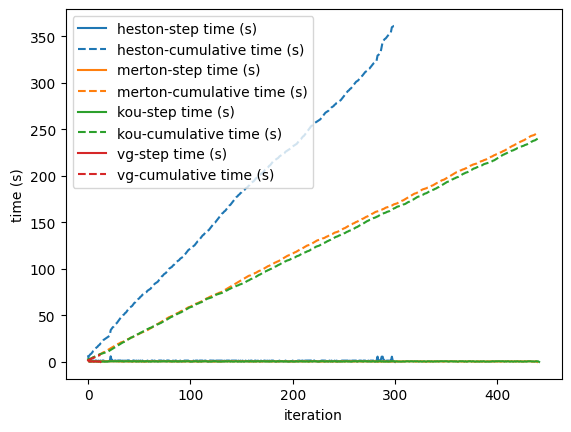

In [53]:
import matplotlib.colors as mcolors

stats = {
    'heston'    : heston_stat,
    'merton'    : merton_stat,
    'kou'       : kou_stat,
    'vg'        : vg_stat
}

for (model_name, time_stat), color in zip(stats.items(), list(mcolors.TABLEAU_COLORS.keys())[:len(stats)]):
    _, steps, cumulatives = zip(*time_stat)
    plot_time_stat(model_name, steps, cumulatives, color)

<Axes: >

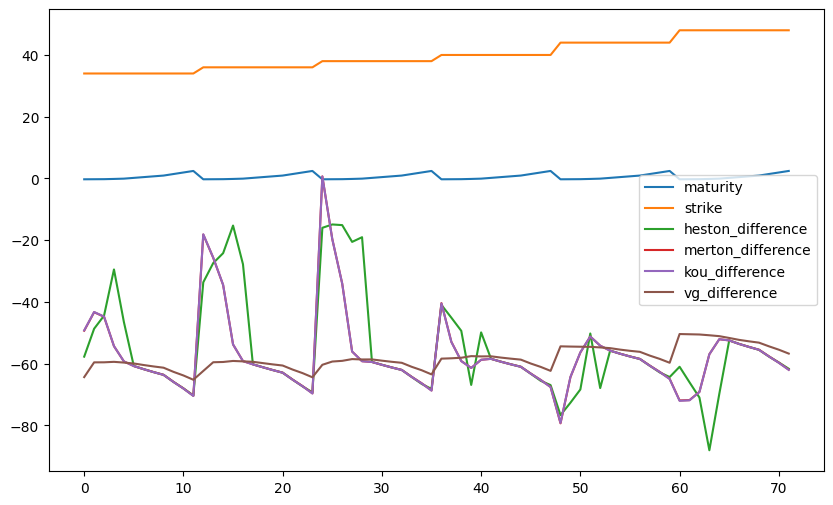

In [54]:
vol_surface_long[['maturity', 'strike', 'heston_difference', 'merton_difference', 'kou_difference', 'vg_difference']].plot.line(figsize=(10, 6))
# plt.yscale('log')